# Black Scholes Model

A European call (put) option is a contract that gives the holder the right, but not obligation, to buy (sell) an underlying asset at a fixed strike price $K$ on some fixed maturity date $T$. The payoff for a European option is given by:
$$ \Psi = \left\{
  \begin{array}{ll}
    \text{max}(S_T - K, 0) & \text{if Call } \\
    \text{max}(K - S_T, 0) & \text{if Put}
  \end{array} \right. $$
Where $S_T$ is the price of the underlying asset at the expiry date $T$.
<br><br> The Black Scholes model, which has the following assumptions, can be used for the pricing of a European option: 
- There exists a money market account that grows at a constant risk-free interest rate, $r$.
- The underlying asset of the option pays a constant dividend yield, $q$, continuously (we deal with the case q=0 in this report).
- There is no arbitrage opportunity.
- There are no transaction costs (frictionless market).
- The underlying asset price follows a geometric Brownian motion with constant drift $\mu$ and volatility $\sigma$, $dS_t = \mu S_tdt + \sigma S_tdW_t$
- A market participant can buy or sell any amount of an asset.

Under these assumptions, one can derive the Black Scholes equation which can be solved analytically to give the formula for the price of a European option at time $t < T$:

$$ V(t) = \left\{
  \begin{array}{ll}
    \Phi(d_1)S_te^{-q(T-t)} - \Phi(d_2)Ke^{-r(T-t)} & \text{if Call } \\
    \Phi(-d_2)Ke^{-r(T-t)} - \Phi(-d_1)S_te^{-q(T-t)} & \text{if Put}
  \end{array} \right. $$

Where $d_1 = \frac{ln(S_t/K) + (r-q+\frac{1}{2}\sigma^2)(T-t)}{\sigma\sqrt{T-t}}$, $d_2 = d_1 - \sigma \sqrt{T-t}$ and $\Phi$ is the cumulative distribution function of the standard normal distribution.


### Parameter estimates

The Black Scholes model has 3 unkown parameters: $\sigma, r$ and $q$. To use the model for pricing options we must estimate these parameters. It seems in general there are two main approaches to this; one is to use known option prices to calibrate the model by determining best estimates for the parameters (e.g. minimising MSE between actual option prices and model predictions). The other is to use historical stock/bond data. 
In this report we  will use the latter to estimate $r$ (using 13 week US T-Bill yields) and both methods to etimate $\sigma$ (the fomer gives what is known as implied volatility, the latter realised volatility). We shall assume $q=0$.

### Realised Volatility 
To estimate the realised volatility we use the maximum likelihood estimator (MLE). Consider a dataset of observations of underlying asset prices $\{S_i\}_{i=0}^n$, with constant time between observations $\Delta t$. Since the Black Scholes model assumes the underlying asset price undergoes a geometric Brownian motion, the log returns of the asset are normally distributed:
$$ R_i = \log\left(\frac{S_{i}}{S_{i-1}} \right) \sim \mathcal{N}\left((\mu-\frac{1}{2}\sigma^2)\Delta t, \sigma^2 \Delta t \right) $$
Given multiple observations $R_1, R_2, ..., R_n$, the likelihood of the parameters $\mu, \sigma^2$ is:
$$ \text{lik}(\mu, \sigma^2) = f(R_1,R_2,...,R_N|\mu, \sigma^2) = \prod_{i=1}^n \frac{1}{\sqrt{2\pi \sigma^2 \Delta t}} \exp \left(-\frac{(R_i - (\mu - \frac{1}{2}\sigma^2)\Delta t)^2}{2\sigma^2 \Delta t}\right )  $$
We can determine the MLEs of $\mu$ and $\sigma^2$ by maximising the logarithm of the likelihood function. We find: 
$$ \hat{\sigma}_{\text{MLE}}^2 = \frac{1}{n\Delta t}\sum_{i=1}^n(R_i - \bar{R})^2 $$

### Implied Volatility
The volatility which makes the option price predicted by the model equal to the actual market option price is called the implied volatility. Consider a set of market prices for $n$ options which all have the same underlying asset and expiry date but different strike prices. The Black Scholes model says that the implied volatility for all $n$ options should be the same. In fact, we find that the implied volatility varies with strike price (known as 'volatility skew'/'volatility smile').
<br><br>This is demonstrated below using data from Yahoo Finance for AAPL stock options. We only calculate the implied volatility for options that are out of the money, since for deep in the money options $\nu = \frac{\partial V}{\partial \sigma} \to 0$ which causes issues with convergence of numerical methods. 




In [51]:
# Following estimates in data_prep notebook
r = 0.049449999882624704
realised_vol = 0.2746527629416358
S = 226.8000030517578
q=0

print(f'Estimate for risk free interest rate, r: {r}')
print(f'Estimate for realised volatility: {realised_vol}')
print(f'Current Apple stock price:{S}')

Estimate for risk free interest rate, r: 0.049449999882624704
Estimate for realised volatility: 0.2746527629416358
Current Apple stock price:226.8000030517578


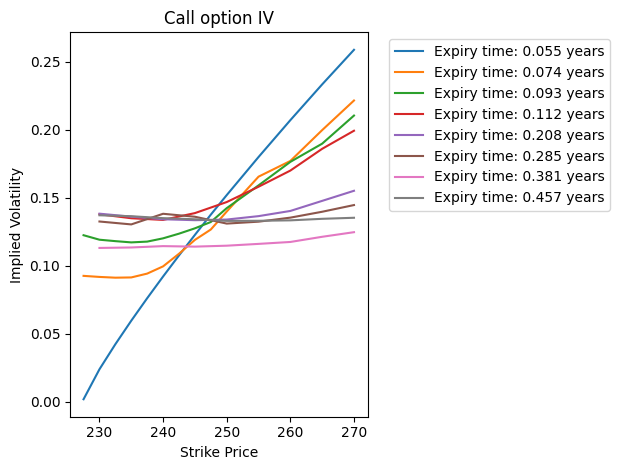

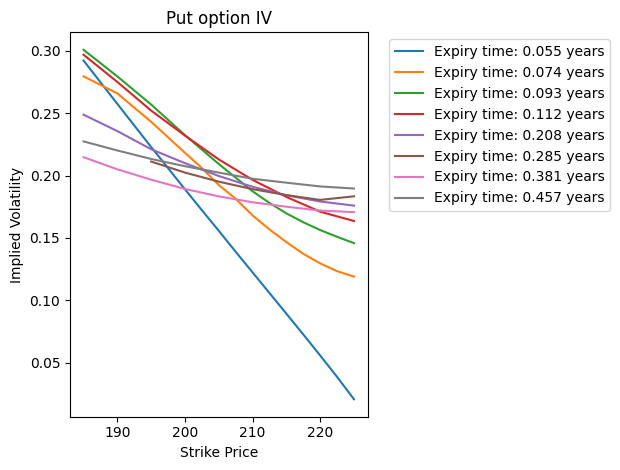

In [52]:
import pandas as pd
import Black_Scholes
import matplotlib.pyplot as plt

options_data = pd.read_csv(r"C:\Users\harve\OneDrive\Documents\Python\VScodeprojects\Option pricing\options_data.csv")
expiry_times = options_data['expiry_time'].unique()


for j in range(len(expiry_times)):
    t = expiry_times[j]
    call_options = options_data.loc[(options_data['option_type'] == 'c') & (options_data['expiry_time'] == t) & (options_data['strike_price'] > S)]
    strike_prices = call_options['strike_price'].values
    market_prices = call_options['market_price'].values
    Implied_vols = []

    for i in range(len(strike_prices)):
        iv = Black_Scholes.implied_volatility('c', S, strike_prices[i], r, t, q, market_prices[i], realised_vol)
        Implied_vols.append(iv)
    plt.plot(strike_prices, Implied_vols, label=f'Expiry time: {t:.3f} years')

plt.xlabel('Strike Price')
plt.ylabel('Implied Volatility')
plt.title('Call option IV')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

for j in range(len(expiry_times)):
    t = expiry_times[j]
    put_options = options_data.loc[(options_data['option_type'] == 'p') & (options_data['expiry_time'] == t) & (options_data['strike_price'] < S)]
    strike_prices = put_options['strike_price'].values
    market_prices = put_options['market_price'].values
    Implied_vols = []

    for i in range(len(strike_prices)):
        iv = Black_Scholes.implied_volatility('p', S, strike_prices[i], r, t, q, market_prices[i], realised_vol)
        Implied_vols.append(iv)
    plt.plot(strike_prices, Implied_vols, label=f'Expiry time: {t:.3f} years')

plt.xlabel('Strike Price')
plt.ylabel('Implied Volatility')
plt.title('Put option IV')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


### Put and Call surfaces
Below we plot call and put surfaces to visualise how the price of European options depend on strike price $K$ and the time to expiry $\tau = T - t$ (with $S=100, r=0.05, \sigma=0.2$ and $q=0$). We see that as $K$ increases the price of a European call decreases and the price of a European put increases. For call options, the price decreases slightly as $\tau \to 0$ when $S \approx K$, but when $S \gg K$ or $S \ll K$ the time to maturity has very little affect on the option price. For put options, we see the price decreases as $\tau \to 0$ when $S$ is less than (but close to) $K$. For deep in the money put options (i.e. $S \ll K$), the price increases as $ \tau \to 0$ (due to the time value of money).


Text(0.5, 200, 'S=100, r=0.05, vol=0.2')

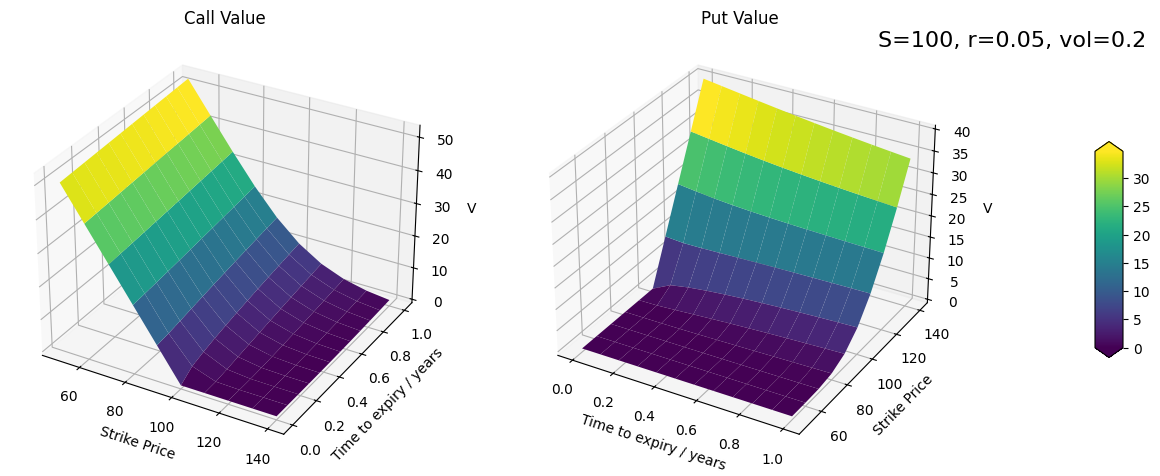

In [3]:
import numpy as np
import math
import Black_Scholes
import matplotlib.pyplot as plt

S = 100 # Initial price of underlying stock
r = 0.05    # Risk free interest rate
v = 0.2 # initial volatility
q = 0   # Assume non dividend paying stock

Strike_prices = np.arange(50, 150, 10)  # range of strike prices
times_to_expiry = np.linspace(0, 1, 12)  # range of times to expiration
K, tau = np.meshgrid(Strike_prices, times_to_expiry)


# Compute option prices using Black-Scholes for all K and T-t
call_prices = np.zeros(K.shape)
put_prices = np.zeros(K.shape)

for i in range(K.shape[0]):
    for j in range(K.shape[1]):
        call_prices[i, j] = Black_Scholes.Black_Scholes_option_price('c', S=100, K=K[i, j], r=0.05, t=tau[i, j], v=0.2, q=0)
        put_prices[i, j] = Black_Scholes.Black_Scholes_option_price('p', S=100, K=K[i, j], r=0.05, t=tau[i, j], v=0.2, q=0)


# Plot call and put surfaces
fig = plt.figure(figsize=(14, 6))

ax = fig.add_subplot(1, 2, 1, projection='3d')
surf = ax.plot_surface(K, tau, call_prices, cmap='viridis')
ax.set_xlabel('Strike Price')
ax.set_ylabel('Time to expiry / years')
ax.set_zlabel('V')
ax.set_title('Call Value')

ax = fig.add_subplot(1, 2, 2, projection='3d')
surf = ax.plot_surface(tau, K, put_prices, cmap='viridis')
ax.set_xlabel('Time to expiry / years')
ax.set_ylabel('Strike Price')
ax.set_zlabel('V')
ax.set_title('Put Value')

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.9, 0.31, 0.02, 0.36])
fig.colorbar(surf, cax=cbar_ax, extend='both')

ax.text(0.5, 200, 40, "S=100, r=0.05, vol=0.2", color='black', fontsize=16)



### The Greeks
The Greeks are quantities that demonstrate the sensitivity of option price to various parameters:

- $\Delta = \frac{\partial{V}}{\partial{S}}$ measures sensitivity of option price to changes in underlying stock price. For a call option, $\Delta$ decreases as Strike price increases (i.e. option becomes less sensitive to changes in the stock price), with $\Delta \in [0, 1]$. For a put option, $\Delta \in [-1, 0]$ and becomes more negative as strike price increases (option becomes more sensitive to changes in the stock price).
 
- $\Gamma = \frac{\partial{\Delta}}{\partial{S}}$ measures sensitivity of $\Delta$ to changes in underlying stock price. $\Gamma$ is always positive for plain vanilla options and has the same value for call and put options with identical characteristics. $\Gamma$ is large when $S \approx K$ and $\Gamma \to 0$ when $ S \gg K$ or $ S \ll K$. For at the money options (i.e. $ S = K$), $\Delta$ becomes a step function when the time to expiry approaches zero and so $\Gamma \to \infty$ as $\tau \to 0$ 

- $\Theta = \frac{\partial{V}}{\partial{t}}$ measures sensitvity of option price to time.  For a European call option (with a non-dividend paying underlying stock) $\Theta$ is always negative, approaching 0 from below when $K \gg S$. For $S=K$, $\Theta$ has a large negative value and the closer to expiry, the more negative. For European put options, $\Theta$ can be positive when $ K \gg S$ but is also negative for $K=S$ (and becomes more negative as $\tau \to 0$).

- $\nu = \frac{\partial{V}}{\partial{\sigma}}$ measures sensitivity of option price to volatility. $\nu$ has the same value for call and put options with identical characteristics and is highest when $S=K$. $\nu$ decreases as $\tau \to 0$ since a long-term option is more sensitive to change in volatility.

The Surface plots below demonstrate these characteristics. All plots have $S=100, r=0.05, \sigma = 0.2$ and $q=0$.



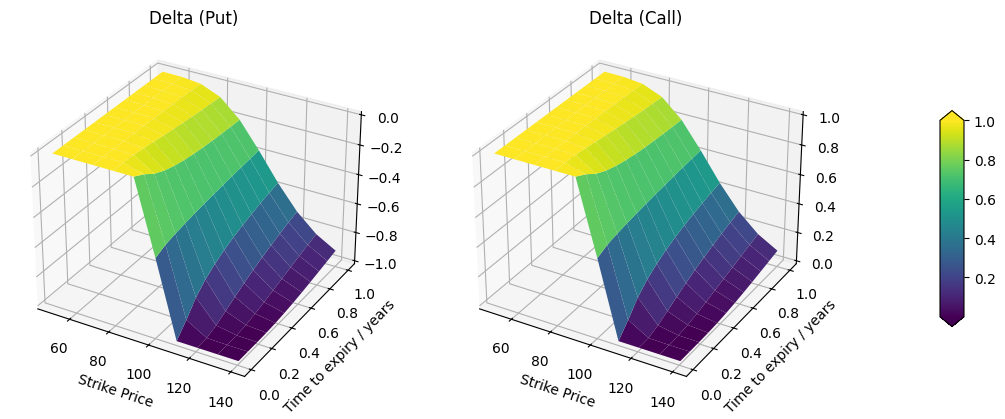

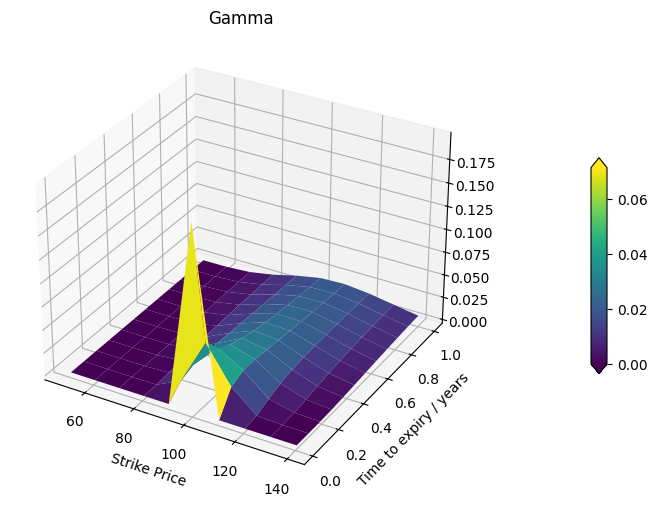

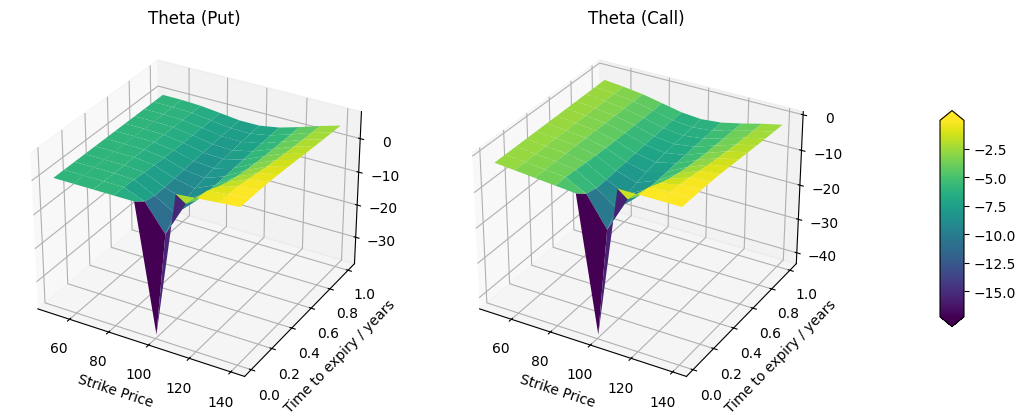

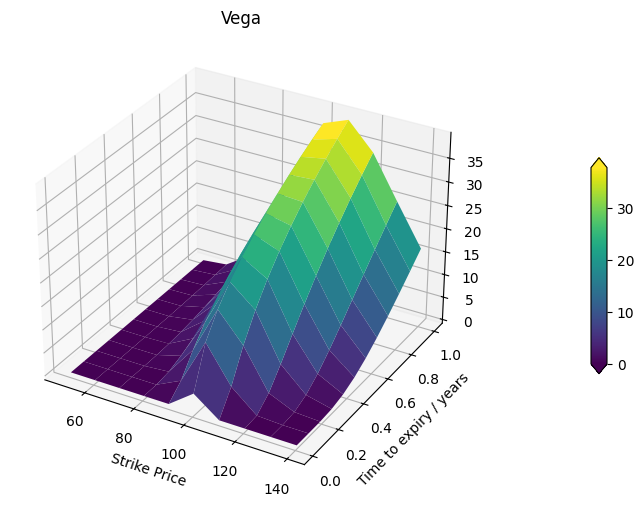

In [4]:
Strike_prices = np.arange(50, 150, 10)  # range of strike prices
times_to_expiry = np.linspace(0.01, 1, 12)  # range of times to expiration
K, tau = np.meshgrid(Strike_prices, times_to_expiry)

delta_put = np.zeros(K.shape)
delta_call = np.zeros(K.shape)
gamma = np.zeros(K.shape)
theta_put = np.zeros(K.shape)
theta_call = np.zeros(K.shape)
vega = np.zeros(K.shape)

for i in range(K.shape[0]):
    for j in range(K.shape[1]):
        delta_call[i, j], gamma[i, j], theta_call[i, j], vega[i, j]  = Black_Scholes.Compute_Greeks('c', S=100, K=K[i, j], r=0.05, t=tau[i, j], v=0.2, q=0)
        delta_put[i, j], _, theta_put[i, j], _  = Black_Scholes.Compute_Greeks('p', S=100, K=K[i, j], r=0.05, t=tau[i, j], v=0.2, q=0)

# Delta
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(1, 2, 1, projection='3d')
surf = ax.plot_surface( K, tau, delta_put, cmap='viridis')
ax.set_xlabel('Strike Price')
ax.set_ylabel('Time to expiry / years')
ax.set_title('Delta (Put)')

ax = fig.add_subplot(1, 2, 2, projection='3d')
surf = ax.plot_surface(K, tau, delta_call, cmap='viridis')
ax.set_xlabel('Strike Price')
ax.set_ylabel('Time to expiry / years')
ax.set_title('Delta (Call)')

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.9, 0.31, 0.02, 0.36])
fig.colorbar(surf, cax=cbar_ax, extend='both')
plt.show()

# Gamma
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(1, 1, 1, projection='3d')
surf = ax.plot_surface(K, tau, gamma, cmap='viridis')
ax.set_xlabel('Strike Price')
ax.set_ylabel('Time to expiry / years')
ax.set_title('Gamma')
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.9, 0.31, 0.02, 0.36])
fig.colorbar(surf, cax=cbar_ax, extend='both')
plt.show()

# Theta
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(1, 2, 1, projection='3d')
surf = ax.plot_surface(K, tau, theta_put, cmap='viridis')
ax.set_xlabel('Strike Price')
ax.set_ylabel('Time to expiry / years')
ax.set_title('Theta (Put)')

ax = fig.add_subplot(1, 2, 2, projection='3d')
surf = ax.plot_surface(K, tau, theta_call, cmap='viridis')
ax.set_xlabel('Strike Price')
ax.set_ylabel('Time to expiry / years')
ax.set_title('Theta (Call)')

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.9, 0.31, 0.02, 0.36])
fig.colorbar(surf, cax=cbar_ax, extend='both')
plt.show()


# Vega
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(1, 1, 1, projection='3d')
surf = ax.plot_surface(K, tau, vega, cmap='viridis')
ax.set_xlabel('Strike Price')
ax.set_ylabel('Time to expiry / years')
ax.set_title('Vega')

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.9, 0.31, 0.02, 0.36])
fig.colorbar(surf, cax=cbar_ax, extend='both')
plt.show()



# Heston model

An alternative model for option pricing, which does not assume constant volatility, is the Heston model. The starting point for the Heston model is the two following stochastic differential equations:
$$ dS_t = rS_tdt + \sqrt{\nu_t}S_tdW_t^{S} $$
$$ d\nu_t = \kappa(\theta - \nu_t)dt + \xi \sqrt{\nu_t}dW_t^{\nu} $$
which model the price of the underlying asset and the volatility of the asset price respectively. 
<br><br>The Brownian motions are correlated with coefficient $\rho$ :
$$ \text{corr}(W_t^{S}, W_t^{\nu}) = \frac{\text{cov}(W_t^{S}, W_t^{\nu})}{\sqrt{\text{var}(W_t^{S})\text{var}(W_t^{\nu})}} = \frac{\mathbb{E[W_t^{S} \cdot W_t^{\nu}]}}{t} = \rho $$ 
<br>WLOG we can take $dW_t^{S} \sim \mathcal{N}(0, dt)$ and $dW_t^{\nu} = \rho dW_t^S + \sqrt{1 - \rho^2}dZ_t $ where $dZ_t \sim \mathcal{N}(0, dt)$.
<br><br>The other model parameters are:
- $\nu_0$, the initial volatility
- $\theta$, the long term mean of $\nu_t$
- $\kappa$, the mean reversion rate (rate at which $\nu_t$ reverts to $\theta$)
- $\xi$, the volatility of volatility
- $r$, the risk free interest rate

There are two different ways to calculate option prices under the Heston model. The first involves generating many possible future paths for the volatility and underlying asset price, via Monte Carlo simulations of the underlying Heston SDEs. The predicted price of the option can then be found by averaging the discounted payoff from each path, since under a risk neutral measure we have:
$$ V(t) = e^{-r(T-t)}\mathbb{E}[V(T)|S_t] $$ 
where $V(T) = \Psi$ is the payoff at maturity.
<br><br>An alternative method is via characteristic functions. Taking inspiration from the Black-Scholes formula, we assume the solution to the Heston equations is of the the form:
$$ V(t) = \left\{
  \begin{array}{ll}
    S_t\Pi_1 - Ke^{-r\tau}\Pi_2 & \text{if Call } \\
    Ke^{-r\tau}(1 - \Pi_2) + S_t(\Pi_1 - 1) & \text{if Put}
  \end{array} \right. $$
It can then be shown that:
$$ \Pi_j = \frac{1}{2} + \frac{1}{\pi}\int_0^{\infty}\mathrm{Re}\left(\frac{e^{-i\phi\ln(K)}f_j(S, \tau, \nu, \phi)}{i\phi}\right)d\phi $$
Where $f_j$ is the characteristic function of the Heston model given by:
$$ f_j(S, \tau, \phi, \nu) = \exp (C(\tau, \phi) + D(\tau, \phi)\nu + i\phi \ln(S))$$
with
$$ C(\tau, \phi) = ir\phi \tau + \frac{a}{\xi ^2}\left((b_j - i\rho \xi \phi + d)\tau - 2\ln\left(\frac{1 - ge^{\tau d}}{1-g}\right)\right) $$
$$ D(\tau, \phi) = \frac{b_j - i\rho \xi \phi +d}{\xi^2}\left(\frac{1 - e^{\tau d}}{1 - ge^{\tau d}}\right) $$
$$ g = \frac{b_j - i\rho \xi \phi + d}{b_j - i\rho \xi \phi -d}$$
$$ d = \sqrt{(i\rho \xi \phi - b_j)^2 - \xi^2(2iu_j\phi - \phi^2)} $$
and $u_1 = \frac{1}{2}, u_2 = -\frac{1}{2}, a = \kappa \theta, b_1 = \kappa - \rho \xi, b_2 = \kappa $.
<br><br>Although the above formulas are messy, they allow us to compute option prices much quicker than via Monte Carlo simulations.

<br> To use the Heston model for options pricing we need to estimate values for the model parameters. Consider the following loss function:
$$ \text{Loss}(\mathbb{\alpha}) = \frac{1}{N}\sum_{i=1}^N \left(V_i^{(m)} - V_i^{(H)}(\mathbb{\alpha})\right)^2 $$
Where $V_i^{(m)}$ is the market option price, $V_i^{(H)}$ is the option price predicted by the Heston model and $\mathbb{\alpha} = (\nu_0, \theta, \kappa, \xi, \rho)$ is the vector of model parameters. The aim is to minimise the loss function by adjusting the parameters. This can be formualted as an optimisation problem:
$$ \mathbb{\alpha^*} = \argmin_{\mathbb{\alpha}}{\text{Loss}(\mathbb{\alpha})} $$
We use the `scipy.optimize` package to solve this problem, giving us estimates for the Heston model parameters.

In [6]:
# This code will take a long time to run
import numpy as np
import pandas as pd
from scipy.optimize import differential_evolution
import Heston  
from sklearn.model_selection import train_test_split

r = 0.049449999882624704
realised_vol = 0.2746527629416358
S = 226.8000030517578
q=0

# Define the Heston loss function
def Loss_function(params, S, r, market_prices, strike_prices, expiry_times, option_types):
    v0, theta, kappa, xi, rho = params

    # Reject solutions that violate the Feller condition
    if 2 * kappa * theta <= xi ** 2:
        return 1e6
    
    predicted_prices = []

    for i in range(len(market_prices)):
        K = strike_prices[i]
        tau = expiry_times[i]
        option_type = option_types[i]
        predicted_prices.append(Heston.Heston_option_price(option_type, S, K, r, tau, v0, kappa, theta, xi, rho))

    mse = np.mean((np.array(market_prices) - np.array(predicted_prices))**2)
    print(f"Params: v0={v0}, theta={theta}, kappa={kappa}, xi={xi}, rho={rho}, MSE: {mse}")
    return mse

# Load options data
options_data = pd.read_csv(r"C:\Users\harve\OneDrive\Documents\Python\VScodeprojects\Option pricing\options_data.csv")
call_options = options_data.loc[options_data['option_type'] == 'c']
put_options = options_data.loc[options_data['option_type'] == 'p']

# Split the data into training and testing sets
# Just consider Call options for simplicity
train_call, test_call = train_test_split(call_options, test_size=10, random_state=42)

train_call_option_types = train_call['option_type'].values
train_call_market_prices = train_call['market_price'].values
train_call_strike_prices = train_call['strike_price'].values
train_call_expiry_times = train_call['expiry_time'].values

# Calibration - minimize the loss function on training data
# We use a Global optimiser as function may have multiple local minima and hence local optimisation would be very dependent on initial guess

bounds = [(0.001, 1.0), (0.001, 1.0), (0.0, 100), (0.01, 5.0), (-1.0, 1.0)] # v0, theta, kappa, xi, rho


result_call = differential_evolution(Loss_function, bounds, args=(S, r, train_call_market_prices, train_call_strike_prices, train_call_expiry_times, 
                                train_call_option_types), maxiter=50, popsize=15, tol=0.05, disp=True)

# Get the optimized Heston parameters
best_params_call = result_call.x
print(f'Optimized Heston parameters: {best_params_call}')




Params: v0=0.9474641583258647, theta=0.983262718499057, kappa=7.915622256771947, xi=0.3389617982966251, rho=-0.6149478893354119, MSE: 812.5367144937667
Params: v0=0.9219860221497057, theta=0.0893366316043277, kappa=17.437204590944802, xi=1.1714669354347584, rho=0.9130524185374611, MSE: 168.0761440770558
Params: v0=0.45848017737968105, theta=0.8220263566913266, kappa=39.64005783201742, xi=2.3182404139181507, rho=0.7655475932868374, MSE: 628.6862407032881
Params: v0=0.5874257190601267, theta=0.4534141436358217, kappa=91.73609236024502, xi=1.0645286100836349, rho=-0.5957483285820568, MSE: 310.3485075044011
Params: v0=0.9717790378017743, theta=0.8455420380707989, kappa=89.18592220710968, xi=3.0528816499151104, rho=-0.14810946060777264, MSE: 697.5025441132565
Params: v0=0.7187238863574669, theta=0.7746792016851802, kappa=52.42934639407206, xi=0.8480327807939398, rho=0.37695337894487047, MSE: 617.3624879364847
Params: v0=0.7984280955149743, theta=0.4271228936252045, kappa=73.45014913450922, 

c:\Users\harve\OneDrive\Documents\Python\VScodeprojects\Option pricing\Heston.py:199: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  result, _ = integrate.quad(integrand, 0, 100)


Params: v0=0.9758713086795233, theta=0.8034545911351907, kappa=69.11072088772211, xi=4.522601817142826, rho=-0.9579298545496092, MSE: 193.17925611639433
Params: v0=0.1553417676680472, theta=0.8625547093107243, kappa=22.73020197305352, xi=4.437236989809099, rho=0.6161155921727297, MSE: 581.346121269011
Params: v0=0.23509687761226555, theta=0.5839294272727996, kappa=78.57287097945294, xi=3.522583205379604, rho=0.5881662281400486, MSE: 335.46470717605985
Params: v0=0.3993477051738836, theta=0.6673949332406761, kappa=93.57695405869123, xi=1.2279687439180447, rho=0.07765518023336582, MSE: 497.9362803518958
Params: v0=0.7782023393233104, theta=0.5245515000476038, kappa=71.74374700866252, xi=3.4579588253816644, rho=0.9872586143319335, MSE: 173.72356570093436
Params: v0=0.031842836630294025, theta=0.14723313426752171, kappa=99.10393964252523, xi=1.3533714211927668, rho=0.7562525423632067, MSE: 53.23366670062352
Params: v0=0.8095994242378931, theta=0.2724086088287611, kappa=34.62396741390184, x

Params: v0=0.001, theta=0.01777864861683034, kappa=30.940516191830316, xi=0.20312676141144922, rho=0.47693415244632925, MSE: 0.22736904407858124
Params: v0=0.001, theta=0.01777864861683034, kappa=30.940516191830316, xi=0.20312676141144922, rho=-1, MSE: 0.2439432302591303
Params: v0=0.001, theta=0.01777864861683034, kappa=30.940516191830316, xi=0.20312676141144922, rho=-0.5, MSE: 0.23527465867009376
Params: v0=0.001, theta=0.01777864861683034, kappa=30.940516191830316, xi=0.20312676141144922, rho=1, MSE: 0.22914171864597788


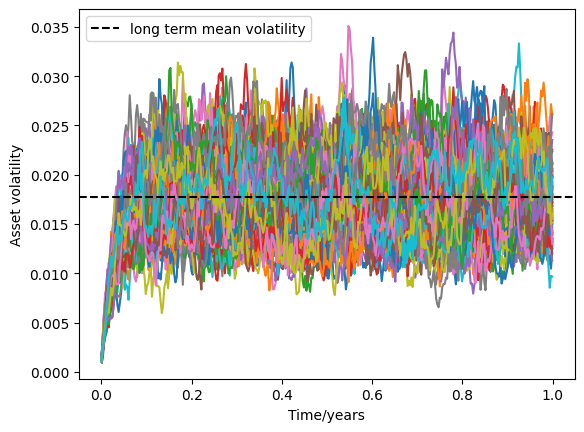

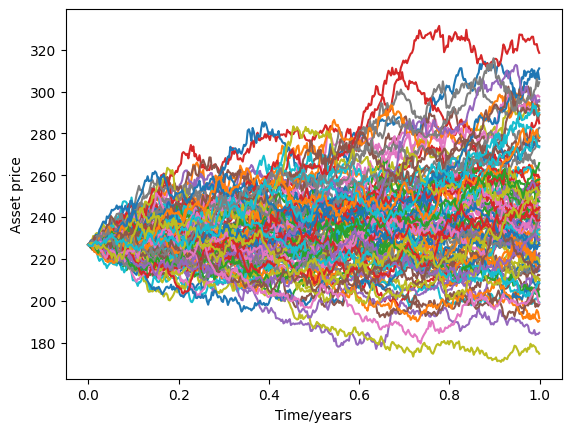

In [37]:
v0 = best_params_call[0]
theta = best_params_call[1]
kappa = best_params_call[2]
xi = best_params_call[3]
rho = best_params_call[4]

# We see that that varying rho over its entire range [-1, 1] has little effect on the MSE
params_1 = (v0, theta, kappa, xi, rho)
params_2 = (v0, theta, kappa, xi, -1)
params_3 = (v0, theta, kappa, xi, -0.5)
params_4 = (v0, theta, kappa, xi, 1)

mse = Loss_function(params_1, S, r, train_call_market_prices, train_call_strike_prices, train_call_expiry_times, train_call_option_types)
mse = Loss_function(params_2, S, r, train_call_market_prices, train_call_strike_prices, train_call_expiry_times, train_call_option_types)
mse = Loss_function(params_3, S, r, train_call_market_prices, train_call_strike_prices, train_call_expiry_times, train_call_option_types)
mse = Loss_function(params_4, S, r, train_call_market_prices, train_call_strike_prices, train_call_expiry_times, train_call_option_types)

times = np.arange(0, 1, 1/365.25)
prices, volatilities = Heston.Heston_stock_paths(S, r, 1, v0, kappa, theta, xi, rho, num_simulations=100)

for i in range(len(volatilities)): 
    plt.plot(times, volatilities[i])
plt.xlabel('Time/years')
plt.ylabel('Asset volatility')
plt.axhline(theta, linestyle='--', color='black', label='long term mean volatility')
plt.legend()
plt.show()

for i in range(len(prices)):
    plt.plot(times, prices[i])
plt.xlabel('Time/years')
plt.ylabel('Asset price')
plt.show()

We can use a similar approach to find a best estimate for the volatility to use in the Black-Scholes model:

In [38]:
from scipy.optimize import minimize

def BS_Loss_function(param, S, r, market_prices, strike_prices, expiry_times, option_types):
    predicted_prices = []

    for i in range(len(market_prices)):
        K = strike_prices[i]
        tau = expiry_times[i]
        option_type = option_types[i]
        predicted_prices.append(Black_Scholes.Black_Scholes_option_price(option_type, S, K, r, tau, param[0], 0))

    mse = np.mean((np.array(market_prices) - np.array(predicted_prices))**2)
    print(f"volatility = {param[0]}, MSE: {mse}")
    return mse

bounds = [(0.001, 5)]
initial_guess = realised_vol

result = minimize(BS_Loss_function, initial_guess, args=(S, r, train_call_market_prices, train_call_strike_prices, train_call_expiry_times, 
                train_call_option_types), bounds=bounds, method='L-BFGS-B')


best_volatility = result.x[0]
print(f'Best volatility: {best_volatility}')

volatility = 0.2746527629416358, MSE: 16.236308772180564
volatility = 0.2746527729416358, MSE: 16.23631118050903
volatility = 0.001, MSE: 3.142312628830167
volatility = 0.00100001, MSE: 3.1423125883618637
volatility = 0.005522328337334772, MSE: 3.117120825003916
volatility = 0.005522338337334772, MSE: 3.1171207432715455
volatility = 0.02361164168667386, MSE: 2.79571867917551
volatility = 0.02361165168667386, MSE: 2.795718430355311
volatility = 0.09596889508403021, MSE: 0.596302305585925
volatility = 0.0959689050840302, MSE: 0.5963020871222113
volatility = 0.38539790867345564, MSE: 56.55636499496403
volatility = 0.38539791867345563, MSE: 56.55636993306756
volatility = 0.11461306476199203, MSE: 0.30557358475558727
volatility = 0.11461307476199202, MSE: 0.3055734987463108
volatility = 0.12426511476460135, MSE: 0.2629040764136507
volatility = 0.12426512476460135, MSE: 0.26290407584685216
volatility = 0.12601608854302437, MSE: 0.2642590065287091
volatility = 0.12601609854302437, MSE: 0.2642

In [39]:
# Compare pricing of the two models
test_call_option_types = test_call['option_type'].values
test_call_market_prices = test_call['market_price'].values
test_call_strike_prices = test_call['strike_price'].values
test_call_expiry_times = test_call['expiry_time'].values

Heston_values = []
Black_Scholes_values = []
for i in range(len(test_call)):
    Heston_price = Heston.Heston_option_price('c', S, test_call_strike_prices[i], r, test_call_expiry_times[i], v0, kappa, theta, xi, rho)
    Black_Scholes_price = Black_Scholes.Black_Scholes_option_price(test_call_option_types[i], S, test_call_strike_prices[i], r, test_call_expiry_times[i], best_volatility, 0)
    Heston_values.append(Heston_price)
    Black_Scholes_values.append(Black_Scholes_price)

test_call['Black_Scholes_price'] = Black_Scholes_values
test_call['Heston_price'] = Heston_values
test_call

,option_type,expiry_time,strike_price,market_price,Black_Scholes_price,Heston_price
251,c,0.380561,225.0,9.60,10.256502,10.399454
221,c,0.284736,215.0,17.05,15.977434,15.952943
247,c,0.380561,205.0,24.70,26.036779,26.039447
105,c,0.093087,210.0,17.75,17.810883,17.773710
185,c,0.208077,190.0,38.60,38.746436,38.745438
55,c,0.073922,212.5,14.90,15.132619,15.072805
289,c,0.457221,240.0,5.05,4.440456,4.746433
101,c,0.093087,195.0,32.60,32.695590,32.696894
191,c,0.208077,220.0,11.30,10.797491,10.697580
278,c,0.457221,185.0,44.65,45.954347,45.953324


We see that the performance between the two models is similar, and the Black Scholes model actually outperforms the Heston model in some cases. This is probably due to the difficulty of calibrating the Heston model parameters. With more advanced methods and additional data and time, the optimisation of the parameters could be improved.
<br><br>An advantage of the Heston model over Black-Scholes, is its ability to capture volatility skew:

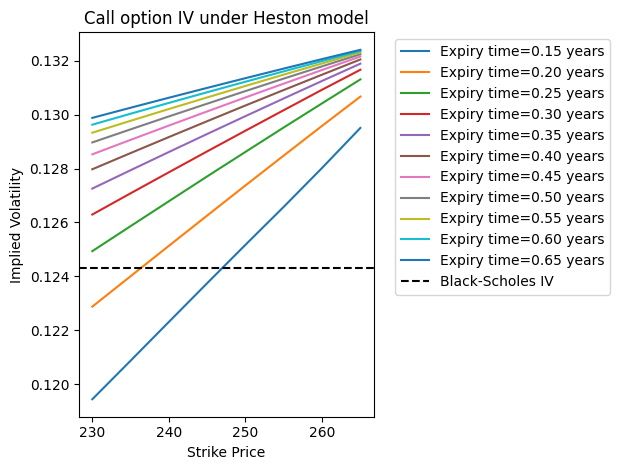

In [50]:
expiry_times = np.arange(0.15, 0.7, 0.05)
strike_prices = np.arange(230, 270, 5)

for t in expiry_times:
    Implied_vols = []
    for K in strike_prices:
        heston_value = Heston.Heston_option_price('c', S, K, r, t, v0, kappa, theta, xi, rho)
        iv = Black_Scholes.implied_volatility('c', S, K, r, t, q, heston_value, realised_vol)
        Implied_vols.append(iv)
    plt.plot(strike_prices, Implied_vols, label=f'Expiry time={t:.2f} years')

plt.xlabel('Strike Price')
plt.ylabel('Implied Volatility')
plt.axhline(best_volatility, linestyle='--', color='black', label='Black-Scholes IV')
plt.title('Call option IV under Heston model')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()